In [2]:
# Import packages and define functions
import random
import numpy as np
import tensorflow as tf
import keras as keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
import xgboost
import time
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed, parallel_backend
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"   # macOS Accelerate / Apple M2
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"
os.environ["TF_NUM_INTEROP_THREADS"] = "1"
os.environ["JOBLIB_TEMP_FOLDER"] = os.environ.get("SLURM_TMPDIR", "/tmp")  # fast local scratch on HPC

# let you control outer workers from env (default: reasonable on laptop)
os.environ.setdefault("N_JOBS", "8")

# Environment settings
os.environ['PYTHONHASHSEED'] = '2024'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Global parameters
d = 15
width = 15
theta = np.hstack((np.array([2, 1.5, 1]), np.zeros(d-3)))

def divide0(a, b):
    # 0/0 = 0 if the empirical probability is zero
    return b and a / b or 0

def fpfn(Y_pred, Y_test, G_test):
    fpg1 = divide0(np.sum((Y_pred == 1) & (Y_test == 0) & (G_test == 1)), np.sum((Y_test == 0) & (G_test == 1)))
    fpg0 = divide0(np.sum((Y_pred == 1) & (Y_test == 0) & (G_test == 0)), np.sum((Y_test == 0) & (G_test == 0)))    
    fng1 = divide0(np.sum((Y_pred == 0) & (Y_test == 1) & (G_test == 1)), np.sum((Y_test == 1) & (G_test == 1)))
    fng0 = divide0(np.sum((Y_pred == 0) & (Y_test == 1) & (G_test == 0)), np.sum((Y_test == 1) & (G_test == 0)))
    return [[fpg0, fng0], [fpg1, fng1]]

def index_compute(G, Z, tau):
    return G + np.dot(Z, theta) + tau * (np.sum(np.square(Z), axis = 1)/d + 2*Z[:, 0]*np.sum(Z[:, 1:], axis = 1))

def classification(tau, rho, n, W, M, seed=2024):    
    def single_iteration(m):
        """Single iteration with unique seed"""
        # Set unique seed for this worker
        iteration_seed = seed + m
        np.random.seed(iteration_seed)
        tf.random.set_seed(iteration_seed)
        random.seed(iteration_seed)
        
        nt = int(0.7*n)
        
        # Initialize models with random_state
        logit_model = LogisticRegression(penalty=None, random_state=iteration_seed)
        
        # GridSearchCV does NOT have random_state parameter - remove it
        lasso_grid = [{'C': np.logspace(-3, 1, 5)}]
        lasso = GridSearchCV(
            LogisticRegression(penalty='l1', solver="liblinear", random_state=iteration_seed), 
            lasso_grid, cv=5, n_jobs=1
        )
        
        svm_grid = [{'C': np.logspace(-1, 1, 5)}]
        svm = GridSearchCV(
            SVC(random_state=iteration_seed), 
            svm_grid, cv=5, n_jobs=1
        )
        
        xgb_grid = [{'n_estimators': [50, 100, 150, 200, 250]}]
        xgb = GridSearchCV(
            xgboost.XGBClassifier(eval_metric='error', random_state=iteration_seed, tree_method='hist', n_jobs=1), 
            xgb_grid, cv=5, n_jobs=1
        )
        
        poly = PolynomialFeatures(degree=2)
        
        # Neural networks with seeded initializers
        sl = keras.models.Sequential([
            keras.Input(shape=[d+1]),
            keras.layers.Dense(
                W, activation='sigmoid',
                kernel_initializer=keras.initializers.GlorotUniform(seed=iteration_seed)
            ),
            keras.layers.Dense(2, activation='relu'),
            keras.layers.Dense(1, activation='linear')
        ])
        sl.compile(optimizer='adam', loss='hinge')
        
        dl = keras.models.Sequential([
            keras.Input(shape=[d+1]),
            keras.layers.Dense(
                W, activation='relu',
                kernel_initializer=keras.initializers.GlorotUniform(seed=iteration_seed)
            ),
            keras.layers.Dense(W, activation='relu'),
            keras.layers.Dense(W, activation='relu'),
            keras.layers.Dense(W, activation='relu'),
            keras.layers.Dense(W, activation='relu'),
            keras.layers.Dense(2, activation='relu'),
            keras.layers.Dense(1, activation='linear')
        ])
        dl.compile(optimizer='adam', loss='hinge')
        
        # Generate data
        G = np.random.binomial(n=1, p=rho, size=n)
        Z = np.random.normal(size=(n, d))
        eps = np.random.normal(size=(n, 1))
        X = np.c_[G, Z]
        index = G + np.dot(Z, theta) + tau * (np.sum(np.square(Z), axis=1)/d + 2*Z[:, 0]*np.sum(Z[:, 1:], axis=1))
        Y = index >= eps[:, 0]
        
        X_train = X[:nt, :]
        X_test = X[nt:, :]
        Y_train = Y[:nt]
        Y_test = Y[nt:]
        G_test = G[nt:]
        
        # Logit
        logit_model.fit(X_train, Y_train)
        Y_l = logit_model.predict(X_test).reshape(-1)
        error_l = np.mean(Y_l != Y_test)
        
        # LASSO
        X_poly = poly.fit_transform(Z)[:, 1:]
        X_train_poly = X_poly[:nt, :]
        X_test_poly = X_poly[nt:, :]
        lasso.fit(X_train_poly, Y_train)
        Y_l1 = lasso.predict(X_test_poly).reshape(-1)
        error_l1 = np.mean(Y_l1 != Y_test)
        
        # SVM
        svm.fit(X_train, Y_train)
        Y_svm = svm.predict(X_test).reshape(-1)
        error_svm = np.mean(Y_svm != Y_test)
        
        # XGBoost
        xgb.fit(X_train, Y_train)
        Y_xgb = xgb.predict(X_test).reshape(-1)
        error_xgb = np.mean(Y_xgb != Y_test)
        
        # Shallow Network
        sl.fit(X_train, 2*Y_train-1, epochs=30, verbose=0)
        Y_sl = np.sign(sl.predict(X_test, verbose=0).reshape(-1)) == 1
        error_sl = np.mean(Y_sl != Y_test)
        
        # Deep Network
        dl.fit(X_train, 2*Y_train-1, epochs=30, verbose=0)
        Y_dl = np.sign(dl.predict(X_test, verbose=0).reshape(-1)) == 1
        error_dl = np.mean(Y_dl != Y_test)
        
        # Calculate errors
        errors = np.concatenate((
            fpfn(Y_l, Y_test, G_test),
            fpfn(Y_l1, Y_test, G_test),
            fpfn(Y_xgb, Y_test, G_test),
            fpfn(Y_svm, Y_test, G_test),
            fpfn(Y_sl, Y_test, G_test),
            fpfn(Y_dl, Y_test, G_test)
        ))
        
        # Clear Keras session
        keras.backend.clear_session()
        
        return {
            'errors': errors,
            'error_l': error_l,
            'error_l1': error_l1,
            'error_svm': error_svm,
            'error_xgb': error_xgb,
            'error_sl': error_sl,
            'error_dl': error_dl
        }
    
    # Run in parallel using joblib
    n_jobs_outer = int(os.environ.get("N_JOBS", "8"))

    with parallel_backend('loky', inner_max_num_threads=1):
        results = Parallel(
            n_jobs=n_jobs_outer,
            backend='loky',
            prefer='processes',
            pre_dispatch=f'2*n_jobs',   # don’t flood the scheduler
            batch_size='auto',          # efficient chunking
            verbose=0
        )(delayed(single_iteration)(m) for m in range(M))
    
    # Aggregate results
    errors = np.zeros([12, 2])
    error_l = error_l1 = error_svm = error_xgb = error_sl = error_dl = 0.0
    
    for result in results:
        errors += result['errors'] / M
        error_l += result['error_l'] / M
        error_l1 += result['error_l1'] / M
        error_svm += result['error_svm'] / M
        error_xgb += result['error_xgb'] / M
        error_sl += result['error_sl'] / M
        error_dl += result['error_dl'] / M
    
    misclass_groups = pd.DataFrame(
        errors,
        columns=['FP', 'FN'],
        index=['Logit', '', 'LASSO', '', 'XGB', '', 'SVM', '', 'SL', '', 'DL', '']
    )
    misclass_groups['Total'] = [
        np.round(error_l, 2), '',
        np.round(error_l1, 2), '',
        np.round(error_xgb, 2), '',
        np.round(error_svm, 2), '',
        np.round(error_sl, 2), '',
        np.round(error_dl, 2), ''
    ]
    
    return misclass_groups


In [2]:
# Table 1: Monte Carlo Simulation Results: symmetric classification. Sample size n = 1,000
# 9 hours to compute.
np.random.seed(2024)
tf.random.set_seed(2024)
random.seed(2024)

experiments = 5000
n = 1000
t0 = time.time()
tab1 = classification(tau = 1, rho = 0.2, n = n, W = width, M = experiments)
tab2 = classification(tau = 1, rho = 0.5, n = n, W = width, M = experiments)
tab3 = classification(tau = 0, rho = 0.2, n = n, W = width, M = experiments)
tab4 = classification(tau = 0, rho = 0.5, n = n, W = width, M = experiments)
group = pd.DataFrame(np.tile([0, 1], 6), tab1.index)
tab = pd.concat((group, tab1, tab2, tab3, tab4), axis = 1)
print(round(tab, 2))

t1 = time.time()
print("Time elapsed: ", t1-t0)

# Save results
with open(f'../tab/tab_1_{n}.tex', 'w') as f:
    f.write(np.round(tab, 2).to_latex(float_format="%.2f"))

print(np.round(tab, 2).to_latex(float_format="%.2f"))


       0    FP    FN Total    FP    FN Total    FP    FN Total    FP    FN  \
Logit  0  0.51  0.24  0.35  0.52  0.24  0.34  0.12  0.12  0.12  0.12  0.12   
       1  0.69  0.13        0.70  0.13        0.17  0.08        0.16  0.08   
LASSO  0  0.17  0.07  0.11  0.22  0.05  0.12  0.14  0.10  0.13  0.19  0.07   
       1  0.09  0.13        0.13  0.10        0.05  0.21        0.08  0.16   
XGB    0  0.30  0.16  0.22  0.32  0.15  0.22  0.16  0.13  0.14  0.18  0.12   
       1  0.32  0.15        0.35  0.13        0.14  0.15        0.17  0.12   
SVM    0  0.26  0.15   0.2  0.27  0.15  0.19  0.16  0.11  0.14  0.19  0.09   
       1  0.31  0.12        0.32  0.11        0.12  0.14        0.18  0.10   
SL     0  0.73  0.10  0.36  0.79  0.07  0.35  0.17  0.12  0.14  0.21  0.09   
       1  0.77  0.07        0.82  0.05        0.19  0.10        0.23  0.08   
DL     0  0.42  0.18  0.27  0.45  0.16  0.27  0.19  0.15  0.17  0.21  0.13   
       1  0.45  0.15        0.48  0.13        0.20  0.13        

In [3]:
# Table 2 and Table OA.1: Monte Carlo Simulation Results: symmetric vs. asymmetric Logit
# 40 minutes to compute
np.random.seed(2024)
tf.random.set_seed(2024)
random.seed(2024)

def logit(phi1, phi0, psi1, psi0, rho, tau, n, M):
    nt = int(0.7*n)
    logit = LogisticRegression(solver = "liblinear")
    wlogit = LogisticRegression(solver = "liblinear")
    ll = np.zeros(M)
    wl = np.zeros(M)

    for m in range(M):
        G = np.random.binomial(n=1, p=rho, size=n)
        Z = np.random.normal(size = (n, d))
        eps = np.random.normal(size = (n, 1))
        X = np.c_[G, Z]
        index = index_compute(G, Z, tau)
        Y = index >= 0.1*eps[:, 0]
        
        X_train = X[:nt, :]
        X_test = X[nt:, :]
        Y_train = Y[:nt]
        Y_test = Y[nt:]
        G_test = G[nt:]

        w = (2*Y-1)*((psi1 - phi1)*G + (psi0 - phi0)*(1-G)) + (psi1 + phi1)*G + (psi0 + phi0)*(1-G)
        w_train = w[:nt]

        logit.fit(X_train, Y_train)
        Y_l = logit.predict(X_test).reshape(-1)
        wlogit.fit(X_train, Y_train, sample_weight = w_train)        
        Y_wl = wlogit.predict(X_test).reshape(-1)
        ll[m] = np.mean((psi1 * G_test + psi0 * (1 - G_test)) * ((Y_test == 1) & (Y_l == 0))
                             + (phi1 * G_test + phi0 * (1 - G_test)) * ((Y_test == 0) & (Y_l == 1)))
        wl[m] = np.mean((psi1 * G_test + psi0 * (1 - G_test)) * ((Y_test == 1) & (Y_wl == 0))
                              + (phi1 * G_test + phi0 * (1 - G_test)) * ((Y_test == 0) & (Y_wl == 1)))

    pr = np.mean(ll > wl)
    summary = pd.DataFrame(ll/wl*(wl>0)).describe()
    return pr, summary

params = [[1, 1.65, 1, 3, 0.2, 0],
            [1, 1.65, 1, 3, 0.5, 0],
            [1, 1.65, 1, 3, 0.2, 1],
            [1, 2, 1, 3, 0.2, 0],
            [1, 1.65, 2, 3, 0.2, 0],
            [1, 1.65, 3, 3, 0.2, 0],
            [1, 1.65, 1, 4, 0.2, 0],
            [1, 1.65, 2, 3, 0.2, 0],
            [1, 1.65, 3, 3, 0.2, 0]]

pr = np.zeros(len(params))
summary1 = np.zeros((5, len(params)))
summary2 = np.zeros((5, len(params)))
summary3 = np.zeros((5, len(params)))

# Compute Table OA.1
t0 = time.time()
M = 5000
# n = 1,000
for i in range(len(params)):
               pr[i], stats = logit(phi1=params[i][0], phi0=params[i][1],
                                   psi1=params[i][2], psi0=params[i][3], rho=params[i][4],
                                   tau = params[i][5], n = 1000, M = M)
               summary1[:, i] = np.array(stats)[3:].reshape(-1)
pr1000 = np.round(pr, 2)         

tab_oa1_n1000 = pd.DataFrame(np.round(summary1, 2))
with open(f'../tab/tab_oa1_n1000.tex', 'w') as f:
    f.write(np.round(tab_oa1_n1000, 2).to_latex(float_format="%.2f"))

print(tab_oa1_n1000.to_latex(float_format="%.2f"))


# n = 5,0000
for i in range(len(params)):
               pr[i], stats = logit(phi1=params[i][0], phi0=params[i][1],
                                   psi1=params[i][2], psi0=params[i][3], rho=params[i][4],
                                   tau = params[i][5], n = 5000, M = M)
               summary2[:, i] = np.array(stats)[3:].reshape(-1)
pr5000 = np.round(pr, 2)         

tab_oa1_n5000 = pd.DataFrame(np.round(summary2, 2))
with open(f'../tab/tab_oa1_n5000.tex', 'w') as f:
    f.write(np.round(tab_oa1_n5000, 2).to_latex(float_format="%.2f"))

print(tab_oa1_n5000.to_latex(float_format="%.2f"))


# n = 10,0000
for i in range(len(params)):
               pr[i], stats = logit(phi1=params[i][0], phi0=params[i][1],
                                   psi1=params[i][2], psi0=params[i][3], rho=params[i][4],
                                   tau = params[i][5], n = 10000, M = M)
               summary3[:, i] = np.array(stats)[3:].reshape(-1)
pr10000 = np.round(pr, 2)         

tab_oa1_n10000 = pd.DataFrame(np.round(summary3, 2))
with open(f'../tab/tab_oa1_n10000.tex', 'w') as f:
    f.write(np.round(tab_oa1_n10000, 2).to_latex(float_format="%.2f"))

print(tab_oa1_n10000.to_latex(float_format="%.2f"))


# Print Table 2
tab2 = pd.DataFrame(np.vstack((pr1000, pr5000, pr10000)), 
                    index=['1,000', '5,000', '10,000'])

t1 = time.time()
print("Time elapsed: ", t1-t0)

with open(f'../tab/tab_2.tex', 'w') as f:
    f.write(np.round(tab2, 2).to_latex(float_format="%.2f"))

print(np.round(tab2, 2).to_latex(float_format="%.2f"))



\begin{tabular}{lrrrrrrrrr}
\toprule
 & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\midrule
0 & 0.00 & 0.00 & 0.77 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
1 & 0.85 & 0.82 & 1.03 & 0.90 & 0.90 & 0.95 & 0.82 & 0.90 & 0.96 \\
2 & 1.06 & 1.00 & 1.09 & 1.06 & 1.13 & 1.20 & 1.08 & 1.14 & 1.22 \\
3 & 1.34 & 1.24 & 1.16 & 1.30 & 1.45 & 1.58 & 1.43 & 1.45 & 1.58 \\
4 & 10.65 & 8.00 & 1.58 & 11.00 & 14.73 & 13.73 & 13.00 & 9.09 & 18.00 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrrr}
\toprule
 & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\midrule
0 & 0.42 & 0.37 & 0.92 & 0.53 & 0.41 & 0.49 & 0.33 & 0.47 & 0.45 \\
1 & 0.91 & 0.89 & 1.03 & 0.93 & 0.94 & 0.97 & 0.91 & 0.94 & 0.97 \\
2 & 1.03 & 1.00 & 1.06 & 1.02 & 1.07 & 1.11 & 1.08 & 1.07 & 1.11 \\
3 & 1.17 & 1.14 & 1.10 & 1.13 & 1.22 & 1.28 & 1.26 & 1.22 & 1.29 \\
4 & 2.47 & 2.36 & 1.25 & 2.03 & 2.81 & 2.72 & 2.78 & 2.53 & 2.59 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrrr}
\toprule
 & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\midrule
0 

In [4]:
# Table 3 and Table OA.2: Monte Carlo Simulation Results: plug-in vs. asymmetric Logit
# 50 minutes to compute
np.random.seed(2024)
tf.random.set_seed(2024)
random.seed(2024)

def logit(phi1, phi0, psi1, psi0, rho, tau, n, M):
    nt = int(0.7*n)
    logit = LogisticRegression(solver = "liblinear")
    wlogit = LogisticRegression(solver = "liblinear")
    ll = np.zeros(M)
    wl = np.zeros(M)
    pl = np.zeros(M)

    for m in range(M):
        G = np.random.binomial(n=1, p=rho, size=n)
        Z = np.random.normal(size = (n, d))
        eps = np.random.normal(size = (n, 1))
        X = np.c_[G, Z]
        index = index_compute(G, Z, tau)
        Y = index >= 0.1*eps[:, 0]
        
        X_train = X[:nt, :]
        X_test = X[nt:, :]
        Y_train = Y[:nt]
        Y_test = Y[nt:]
        G_test = G[nt:]

        w = (2*Y-1)*((psi1 - phi1)*G + (psi0 - phi0)*(1-G)) + (psi1 + phi1)*G + (psi0 + phi0)*(1-G)
        w_train = w[:nt]

        logit.fit(X_train, Y_train)
        #Y_l = logit.predict(X_test).reshape(-1)
        wlogit.fit(X_train, Y_train, sample_weight = w_train)        
        Y_wl = wlogit.predict(X_test).reshape(-1)
        c = G_test * phi1/(phi1+psi1) + (1-G_test) * phi0/(phi0+psi0)
        Y_p = 2*(logit.predict_proba(X_test)[:, 1] > c) - 1

        wl[m] = np.mean((psi1 * G_test + psi0 * (1 - G_test)) * ((Y_test == 1) & (Y_wl == 0))
                        + (phi1 * G_test + phi0 * (1 - G_test)) * ((Y_test == 0) & (Y_wl == 1)))
        pl[m] = np.mean((psi1 * G_test + psi0 * (1 - G_test)) * ((Y_test == 1) & (Y_p == 0))
                        + (phi1 * G_test + phi0 * (1 - G_test)) * ((Y_test == 0) & (Y_p == 1)))

    pr = np.mean(pl > wl)
    summary = pd.DataFrame(pl/wl*(wl>0)).describe()
    return pr, summary


params = [[1, 1.65, 1, 3, 0.2, 0],
            [1, 1.65, 1, 3, 0.5, 0],
            [1, 1.65, 1, 3, 0.2, 1],
            [1, 2, 1, 3, 0.2, 0],
            [1, 1.65, 2, 3, 0.2, 0],
            [1, 1.65, 3, 3, 0.2, 0],
            [1, 1.65, 1, 4, 0.2, 0],
            [1, 1.65, 2, 3, 0.2, 0],
            [1, 1.65, 3, 3, 0.2, 0]]

pr = np.zeros(len(params))
summary = np.zeros((5, len(params)))

# Compute Table OA.2
# n = 1,000
for i in range(len(params)):
               pr[i], stats = logit(phi1=params[i][0], phi0=params[i][1],
                                   psi1=params[i][2], psi0=params[i][3], rho=params[i][4],
                                   tau = params[i][5], n = 1000, M = experiments)
               summary[:, i] = np.array(stats)[3:].reshape(-1)
pr1000 = np.round(pr, 2)         

tab_oa2_n1000 = pd.DataFrame(np.round(summary, 2))
with open(f'../tab/tab_oa2_n1000.tex', 'w') as f:
    f.write(np.round(tab_oa2_n1000, 2).to_latex(float_format="%.2f"))

print(tab_oa2_n1000.to_latex(float_format="%.2f"))

# n = 5,0000
for i in range(len(params)):
               pr[i], stats = logit(phi1=params[i][0], phi0=params[i][1],
                                   psi1=params[i][2], psi0=params[i][3], rho=params[i][4],
                                   tau = params[i][5], n = 5000, M = experiments)
               summary[:, i] = np.array(stats)[3:].reshape(-1)
pr5000 = np.round(pr, 2)         

tab_oa2_n5000 = pd.DataFrame(np.round(summary, 2))
with open(f'../tab/tab_oa2_n5000.tex', 'w') as f:
    f.write(np.round(tab_oa2_n5000, 2).to_latex(float_format="%.2f"))

print(tab_oa2_n5000.to_latex(float_format="%.2f"))

# n = 10,0000
for i in range(len(params)):
               pr[i], stats = logit(phi1=params[i][0], phi0=params[i][1],
                                   psi1=params[i][2], psi0=params[i][3], rho=params[i][4],
                                   tau = params[i][5], n = 10000, M = experiments)
               summary[:, i] = np.array(stats)[3:].reshape(-1)
pr10000 = np.round(pr, 2)         

tab_oa2_n10000 = pd.DataFrame(np.round(summary, 2))
with open(f'../tab/tab_oa2_n10000.tex', 'w') as f:
    f.write(np.round(tab_oa2_n10000, 2).to_latex(float_format="%.2f"))

print(tab_oa2_n10000.to_latex(float_format="%.2f"))

# Print Table 3
tab3 = pd.DataFrame(np.vstack((pr1000, pr5000, pr10000)), 
                    index=['1,000', '5,000', '10,000'],
                    columns=[f'Param_{i+1}' for i in range(len(params))])

tab3_rounded = tab3.round(2)
with open(f'../tab/tab_3.tex', 'w') as f:
    f.write(tab3_rounded.to_latex(float_format="%.2f"))

print(tab3_rounded.to_latex(float_format="%.2f"))


\begin{tabular}{lrrrrrrrrr}
\toprule
 & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\midrule
0 & 0.10 & 0.00 & 0.54 & 0.00 & 0.20 & 0.21 & 0.27 & 0.18 & 0.23 \\
1 & 1.02 & 0.88 & 0.76 & 0.82 & 1.07 & 1.13 & 1.28 & 1.08 & 1.12 \\
2 & 1.31 & 1.16 & 0.81 & 1.10 & 1.39 & 1.45 & 1.63 & 1.40 & 1.44 \\
3 & 1.68 & 1.53 & 0.86 & 1.43 & 1.80 & 1.87 & 2.09 & 1.80 & 1.86 \\
4 & 11.55 & 10.90 & 1.01 & 15.00 & 11.90 & 12.90 & 18.15 & 17.85 & 21.50 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrrr}
\toprule
 & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\midrule
0 & 0.45 & 0.36 & 0.71 & 0.30 & 0.51 & 0.57 & 0.62 & 0.51 & 0.54 \\
1 & 1.01 & 0.88 & 0.82 & 0.83 & 1.06 & 1.11 & 1.24 & 1.06 & 1.11 \\
2 & 1.15 & 1.03 & 0.84 & 0.97 & 1.21 & 1.27 & 1.42 & 1.22 & 1.27 \\
3 & 1.33 & 1.19 & 0.86 & 1.12 & 1.39 & 1.45 & 1.63 & 1.39 & 1.45 \\
4 & 2.76 & 3.10 & 0.94 & 2.70 & 2.59 & 3.18 & 3.68 & 2.74 & 3.47 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrrr}
\toprule
 & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\midrule


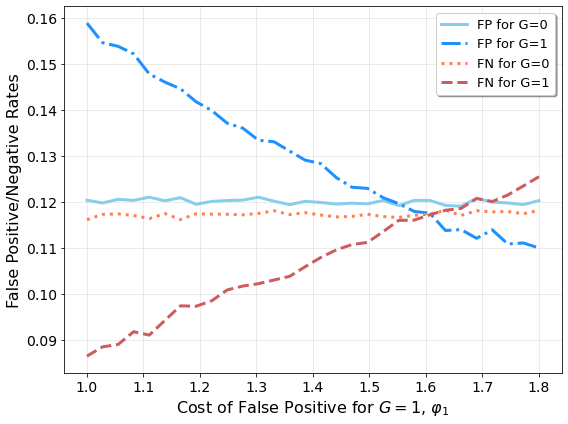

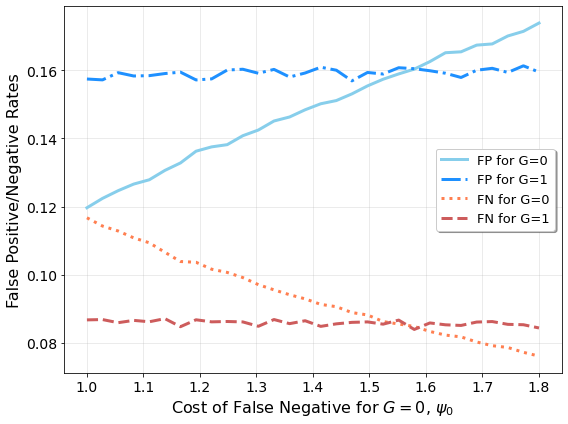

Time elapsed:  697.6256279945374


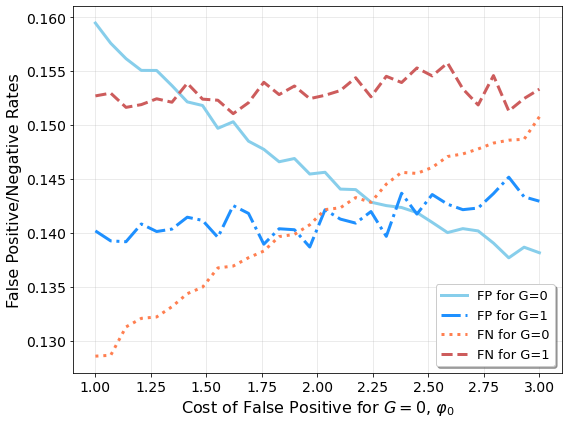

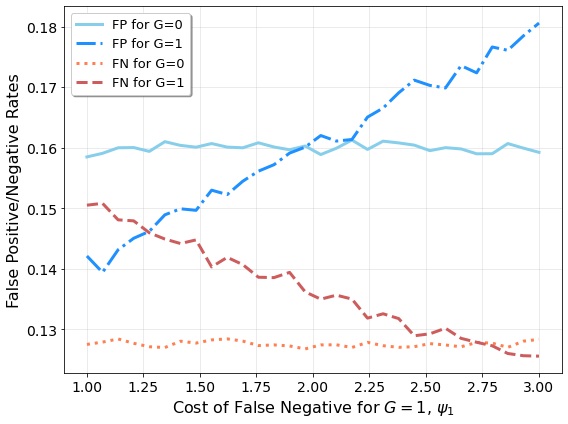

Time elapsed:  5588.783407926559


In [5]:
# Figure 3: Asymmetric Binary Choice
# 3 hours to compute
np.random.seed(2024)
tf.random.set_seed(2024)
random.seed(2024)

# Set style parameters
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['grid.alpha'] = 0.3

def logit(phi1, phi0, psi1, psi0, tau, n, M, erm):
    rho = 0.2
    nt = int(0.7*n)
    logit = LogisticRegression(solver = "liblinear")
    total = 0
    errors = np.zeros([2, 2])

    for m in range(M):
        G = np.random.binomial(n=1, p=rho, size=n)
        Z = np.random.normal(size = (n, d))
        eps = np.random.normal(size = (n, 1))
        X = np.c_[G, Z]
        index = index_compute(G, Z, tau)
        Y = index >= eps[:, 0]
        
        X_train = X[:nt, :]
        X_test = X[nt:, :]
        Y_train = Y[:nt]
        Y_test = Y[nt:]
        G_test = G[nt:]

        w = (2*Y-1)*((psi1 - phi1)*G + (psi0 - phi0)*(1-G)) + (psi1 + phi1)*G + (psi0 + phi0)*(1-G)
        w_train = w[:nt]
        
        logit.fit(X_train, Y_train, sample_weight = w_train)
        if erm == 1:
            Y_l = logit.predict(X_test).reshape(-1)
        else:
            c = G_test * phi1/(phi1+psi1) + (1-G_test) * phi0/(phi0+psi0)
            Y_l = logit.predict_proba(X_test)[:, 1] > c
            
        total = total + np.mean(Y_l != Y_test) / M
        errors = errors + fpfn(Y_l, Y_test, G_test)   
    return total, errors / M

def gb(phi1, phi0, psi1, psi0, tau, n, M, erm):
    """Parallelized gradient boosting function using joblib"""
    rho = 0.2
    nt = int(0.7*n)
    
    def single_gb_iteration(m):
        """Single iteration for gradient boosting"""
        
        # Initialize model
        xgb = xgboost.XGBClassifier(
            n_estimators=150, 
            eval_metric='error'
        )
        
        # Generate data
        G = np.random.binomial(n=1, p=rho, size=n)
        Z = np.random.normal(size=(n, d))
        eps = np.random.normal(size=(n, 1))
        X = np.c_[G, Z]
        index = index_compute(G, Z, tau)
        Y = index >= eps[:, 0]
        
        X_train = X[:nt, :]
        X_test = X[nt:, :]
        Y_train = Y[:nt]
        Y_test = Y[nt:]
        G_test = G[nt:]
        
        # Calculate sample weights
        w = (2*Y-1)*((psi1 - phi1)*G + (psi0 - phi0)*(1-G)) + (psi1 + phi1)*G + (psi0 + phi0)*(1-G)
        w_train = w[:nt]
        
        # Fit and predict
        xgb.fit(X_train, Y_train, sample_weight=w_train)
        
        if erm == 1:
            Y_gb = xgb.predict(X_test).reshape(-1)
        else:
            c = G_test * phi1/(phi1+psi1) + (1-G_test) * phi0/(phi0+psi0)
            Y_gb = xgb.predict_proba(X_test)[:, 1] > c
        
        # Calculate metrics for this iteration
        iter_total = np.mean(Y_gb != Y_test)
        iter_errors = np.array(fpfn(Y_gb, Y_test, G_test))
        
        return {
            'total': iter_total,
            'errors': iter_errors
        }
    
    # Run in parallel
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(single_gb_iteration)(m) for m in range(M)
    )
    
    # Aggregate results
    total = np.zeros(1)
    errors = np.zeros([2, 2])
    
    for result in results:
        total += result['total'] / M
        errors += result['errors'] / M
    
    return total, errors

d = 15
experiments = 5000
sample_size = 1000
grid_length = 30
errors1 = np.empty([2, 2, grid_length])
errors2 = np.empty([2, 2, grid_length])
errors3 = np.empty([2, 2, grid_length])
errors4 = np.empty([2, 2, grid_length])

total1 = np.empty(grid_length)
total2 = np.empty(grid_length)
total3 = np.empty(grid_length)
total4 = np.empty(grid_length)

# Logit: false positive rates
t0 = time.time()
grid = np.linspace(1, 1.8, grid_length)
for i in range(grid_length):
    total1[i], errors1[:, :, i] = logit(phi1 = grid[i], phi0 = 1,
                                   psi1 = 1, psi0 = 1, tau = 0,
                                   n = sample_size, M = experiments,
                                   erm = 1)
    
f, ax = plt.subplots(figsize=(8, 6))
ax.plot(grid, errors1[0, 0, :], color='skyblue', linestyle='-', linewidth=3, label='FP for G=0')
ax.plot(grid, errors1[1, 0, :], color='dodgerblue', linestyle='-.', linewidth=3, label='FP for G=1')
ax.plot(grid, errors1[0, 1, :], color='coral', linestyle=':', linewidth=3, label='FN for G=0')
ax.plot(grid, errors1[1, 1, :], color='indianred', linestyle='--', linewidth=3, label='FN for G=1')
ax.set_xlabel(r'Cost of False Positive for $G=1$, $\varphi_1$', fontsize=16)
ax.set_ylabel('False Positive/Negative Rates', fontsize=16)
ax.legend(frameon=True, fancybox=True, shadow=True, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
f.savefig("../fig/fig_3a.pdf", bbox_inches='tight', dpi=300)

# Logit: false negative rates
grid = np.linspace(1, 1.8, grid_length)
for i in range(grid_length):
    total2[i], errors2[:, :, i] = logit(phi1 = 1, phi0 = 1,
                                   psi1 = 1, psi0 = grid[i], tau = 0,
                                   n = sample_size, M = experiments,
                                   erm = 1)

f, ax = plt.subplots(figsize=(8, 6))
ax.plot(grid, errors2[0, 0, :], color='skyblue', linestyle='-', linewidth=3, label='FP for G=0')
ax.plot(grid, errors2[1, 0, :], color='dodgerblue', linestyle='-.', linewidth=3, label='FP for G=1')
ax.plot(grid, errors2[0, 1, :], color='coral', linestyle=':', linewidth=3, label='FN for G=0')
ax.plot(grid, errors2[1, 1, :], color='indianred', linestyle='--', linewidth=3, label='FN for G=1')
ax.set_xlabel(r'Cost of False Negative for $G=0$, $\psi_0$', fontsize=16)
ax.set_ylabel('False Positive/Negative Rates', fontsize=16)
ax.legend(frameon=True, fancybox=True, shadow=True, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
f.savefig("../fig/fig_3b.pdf", bbox_inches='tight', dpi=300)

t1 = time.time()
print("Time elapsed: ", t1-t0)

# Boosting: false positive rates
t0 = time.time()
grid = np.linspace(1, 3, grid_length)
for i in range(grid_length):
    total3[i], errors3[:, :, i] = gb(phi1 = 1, phi0 = grid[i],
                                   psi1 = 1, psi0 = 1, tau = 0,
                                   n = sample_size, M = experiments,
                                   erm = 1)

f, ax = plt.subplots(figsize=(8, 6))
ax.plot(grid, errors3[0, 0, :], color='skyblue', linestyle='-', linewidth=3, label='FP for G=0')
ax.plot(grid, errors3[1, 0, :], color='dodgerblue', linestyle='-.', linewidth=3, label='FP for G=1')
ax.plot(grid, errors3[0, 1, :], color='coral', linestyle=':', linewidth=3, label='FN for G=0')
ax.plot(grid, errors3[1, 1, :], color='indianred', linestyle='--', linewidth=3, label='FN for G=1')
ax.set_xlabel(r'Cost of False Positive for $G=0$, $\varphi_0$', fontsize=16)
ax.set_ylabel('False Positive/Negative Rates', fontsize=16)
ax.legend(frameon=True, fancybox=True, shadow=True, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
f.savefig("../fig/fig_3c.pdf", bbox_inches='tight', dpi=300)

# Boosting: false negative rates
grid = np.linspace(1, 3, grid_length)
for i in range(grid_length):
    total4[i], errors4[:, :, i] = gb(phi1 = 1, phi0 = 1,
                                   psi1 = grid[i], psi0 = 1, tau = 0,
                                   n = sample_size, M = experiments,
                                   erm = 1)
    
f, ax = plt.subplots(figsize=(8, 6))
ax.plot(grid, errors4[0, 0, :], color='skyblue', linestyle='-', linewidth=3, label='FP for G=0')
ax.plot(grid, errors4[1, 0, :], color='dodgerblue', linestyle='-.', linewidth=3, label='FP for G=1')
ax.plot(grid, errors4[0, 1, :], color='coral', linestyle=':', linewidth=3, label='FN for G=0')
ax.plot(grid, errors4[1, 1, :], color='indianred', linestyle='--', linewidth=3, label='FN for G=1')
ax.set_xlabel(r'Cost of False Negative for $G=1$, $\psi_1$', fontsize=16)
ax.set_ylabel('False Positive/Negative Rates', fontsize=16)
ax.legend(frameon=True, fancybox=True, shadow=True, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
f.savefig("../fig/fig_3d.pdf", bbox_inches='tight', dpi=300)

t1 = time.time()
print("Time elapsed: ", t1-t0)

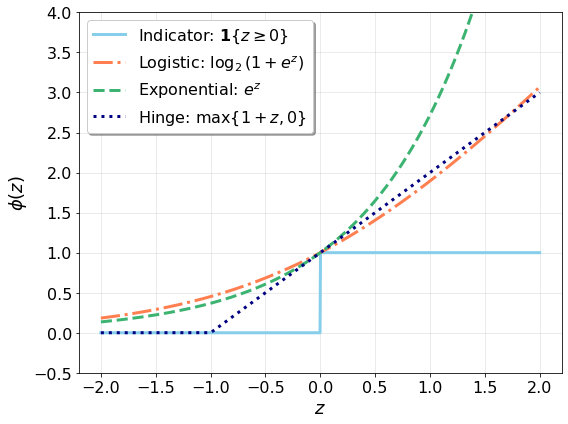

In [6]:
# Figure 1: Convexifications of the Indicator Function
x = np.linspace(-2, 2, 1000)
indicator = (x >= 0).astype(float)
logistic_surrogate = np.log(1 + np.exp(x)) / np.log(2)   # log2(1 + e^x)
exponential = np.exp(x)
hinge = np.maximum(1 + x, 0)

plt.figure(figsize=(8, 6))
plt.plot(x, indicator, color='skyblue', linestyle='-', linewidth=3, label=r'Indicator: $\mathbf{1}\{z\geq 0\}$')
plt.plot(x, logistic_surrogate, color='coral', linestyle='-.', linewidth=3, label=r'Logistic: $\log_2(1+e^{z})$')
plt.plot(x, exponential, color='mediumseagreen', linestyle='--', linewidth=3, label=r'Exponential: $e^z$')
plt.plot(x, hinge, color='navy', linestyle=':', linewidth=3, label=r'Hinge: $\max\{1+z,0\}$')
plt.ylim([-0.5, 4])
plt.xlabel(r'$z$', fontsize=18, fontweight='bold')
plt.ylabel(r'$\phi(z)$', fontsize=18, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left', fontsize=16, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../fig/fig_1.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# Table 1: Monte Carlo Simulation Results: symmetric classification.
# 12 hours to compute.
np.random.seed(2024)
tf.random.set_seed(2024)
random.seed(2024)

experiments = 1000

# Sample size n = 10,000.
n = 10000
t0 = time.time()
tab1 = classification(tau = 1, rho = 0.2, n = n, W = width, M = experiments)
tab2 = classification(tau = 1, rho = 0.5, n = n, W = width, M = experiments)
tab3 = classification(tau = 0, rho = 0.2, n = n, W = width, M = experiments)
tab4 = classification(tau = 0, rho = 0.5, n = n, W = width, M = experiments)
group = pd.DataFrame(np.tile([0, 1], 6), tab1.index)
tab = pd.concat((group, tab1, tab2, tab3, tab4), axis = 1)
print(round(tab, 2))

t1 = time.time()
print("Time elapsed: ", t1-t0)

with open(f'../tab/tab_1_{n}.tex', 'w') as f:
    f.write(np.round(tab, 2).to_latex(float_format="%.2f"))

print(np.round(tab, 2).to_latex(float_format="%.2f"))


       0    FP    FN Total    FP    FN Total    FP    FN Total    FP    FN  \
Logit  0  0.51  0.22  0.34  0.52  0.22  0.33  0.11  0.11  0.11  0.11  0.11   
       1  0.71  0.11        0.72  0.10        0.16  0.08        0.16  0.08   
LASSO  0  0.12  0.05  0.08  0.16  0.03  0.08  0.13  0.10  0.12  0.19  0.06   
       1  0.04  0.11        0.06  0.08        0.04  0.21        0.07  0.15   
XGB    0  0.16  0.10  0.12  0.17  0.10  0.12  0.13  0.12  0.13  0.14  0.12   
       1  0.20  0.08        0.20  0.07        0.16  0.10        0.16  0.10   
SVM    0  0.14  0.08   0.1  0.14  0.08   0.1  0.13  0.10  0.12  0.14  0.09   
       1  0.17  0.06        0.17  0.05        0.12  0.11        0.15  0.08   
SL     0  0.24  0.07  0.14  0.25  0.07  0.13  0.15  0.11  0.13  0.15  0.11   
       1  0.25  0.05        0.26  0.05        0.19  0.08        0.19  0.07   
DL     0  0.18  0.07  0.12  0.20  0.07  0.12  0.15  0.12  0.13  0.15  0.12   
       1  0.19  0.06        0.21  0.05        0.19  0.09        